# **IMPORTS**

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.callback import EarlyStopping
from sklearn.metrics import accuracy_score
import shap
shap.initjs()
import plotly.io as pio
pio.renderers.default = "png"
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from IPython.display import display
print(xgb.__version__)


2.1.4


# **EDA**

### _Loading The Data_

In [134]:
#Loading the batting, bowling, and fielding datasets
bat_df = pd.read_excel("/Users/mukundranjan/Documents/Academics/Easter/Dissertation/Diss Code and DBs/Databases/batting.xlsx")
bowl_df = pd.read_excel("/Users/mukundranjan/Documents/Academics/Easter/Dissertation/Diss Code and DBs/Databases/bowling.xlsx")
field_df = pd.read_excel("/Users/mukundranjan/Documents/Academics/Easter/Dissertation/Diss Code and DBs/Databases/fielding.xlsx")


#Cleaning the batting data
bat_df = bat_df.dropna(how='all')
bat_df = bat_df.dropna(axis=1, how='all')
bat_df.reset_index(drop=True, inplace=True)
bat_df['High Score Not Out'] = bat_df['High Score Not Out'].map({'Yes': 1, 'No': 0})


#Cleaning the bowling data
bow_df = bowl_df.dropna(how='all')
bow_df = bowl_df.dropna(axis=1, how='all')
bowl_df.reset_index(drop=True, inplace=True)

#Cleaning the fielding data
field_df = field_df.dropna(how='all')
field_df = field_df.dropna(axis=1, how='all')
field_df.reset_index(drop=True, inplace=True)

field_df.shape #quick test to ensure cleaning has worked and not messed up the dataset
field_df.head()

#Merging the three datasets into a single  dataset for EDA and modelling
merged = pd.merge(bat_df, bowl_df, on="Player", how="outer")
merged = pd.merge(merged, field_df, on="Player", how="outer") 
merged = merged.fillna(0)
merged = merged.drop(['Club', 'Club_x', 'Club_y'], axis=1)
merged['GAMES'] = merged['GAMES'].replace(0, np.nan)
display(merged.head())
print(merged.shape)

print(merged.columns.tolist())

print(merged['GAMES'].isnull().sum())
predictors = ['GAMES', 'OVERS', 'WICKETS', ' RUNS CONCEDED', 'BOWL AVERAGE', 'BOWL STRIKE RATE', 'ECONOMY RATE', 'TOTAL CATCHES', 'TOTAL VICTIMS']
impute_df = merged[predictors]
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imputer.fit_transform(impute_df)
df_imputed = pd.DataFrame(df_imputed, columns=predictors)

#Rounding and setting "Games" column back into the original dataset
merged['GAMES'] = df_imputed['GAMES'].round().astype(int)

merged.to_csv("merged_data.csv", index=False)




,Player,GAMES,INNS,NOT OUTS,RUNS,HIGH SCORE,High Score Not Out,AVG,50s,100s,...,BOWL STRIKE RATE,BOWL AVERAGE,WICKET KEEPING CATCHES,STUMPINGS,TOTAL WICKET KEEPING WICKETS,FIELDING CATCHES,RUN OUTS,TOTAL FIELDING WICKETS,TOTAL CATCHES,TOTAL VICTIMS
0,Aaron Grey,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,30.17,31.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alex Bramley,13.0,12.0,2.0,194.0,50.0,1.0,19.40,1.0,0.0,...,0.00,0.00,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2,Alfie Armstrong,19.0,17.0,9.0,219.0,52.0,1.0,27.38,2.0,0.0,...,22.75,19.69,0.0,0.0,0.0,7.0,1.0,8.0,7.0,8.0
3,Alfie Blenkiron,13.0,10.0,6.0,270.0,51.0,1.0,67.50,1.0,0.0,...,36.33,24.67,1.0,0.0,1.0,3.0,1.0,4.0,4.0,5.0
4,Brody McCann,8.0,3.0,0.0,2.0,1.0,0.0,0.67,0.0,0.0,...,24.17,19.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(588, 29)
['Player', 'GAMES', 'INNS', 'NOT OUTS', 'RUNS', 'HIGH SCORE', 'High Score Not Out', 'AVG', '50s', '100s', 'STRIKE RATE', 'Unnamed: 0', 'OVERS', 'MAIDENS', ' RUNS CONCEDED', 'WICKETS', 'BEST BOWLING', '5 WICKET HAUL', 'ECONOMY RATE', 'BOWL STRIKE RATE', 'BOWL AVERAGE', 'WICKET KEEPING CATCHES', 'STUMPINGS', 'TOTAL WICKET KEEPING WICKETS', 'FIELDING CATCHES', 'RUN OUTS', 'TOTAL FIELDING WICKETS', 'TOTAL CATCHES', 'TOTAL VICTIMS']
559


### Loading the Merged and Fixed Dataset for Final Use

In [135]:
cdata = pd.read_csv("/Users/mukundranjan/Documents/Academics/Easter/Dissertation/Diss Code and DBs/Databases/merged data/cdata.csv") 
print(cdata.shape)
print(cdata.info())
print(cdata.describe())
print(cdata['SELECTION'].value_counts())

(50, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Player                        50 non-null     object 
 1   GAMES                         50 non-null     float64
 2   INNS                          50 non-null     float64
 3   NOT OUTS                      50 non-null     float64
 4   RUNS                          50 non-null     float64
 5   HIGH SCORE                    50 non-null     float64
 6   AVG                           50 non-null     float64
 7   50s                           50 non-null     float64
 8   100s                          50 non-null     float64
 9   STRIKE RATE                   50 non-null     float64
 10  OVERS                         50 non-null     float64
 11  MAIDENS                       50 non-null     float64
 12   RUNS CONCEDED                50 non-null     float64
 13

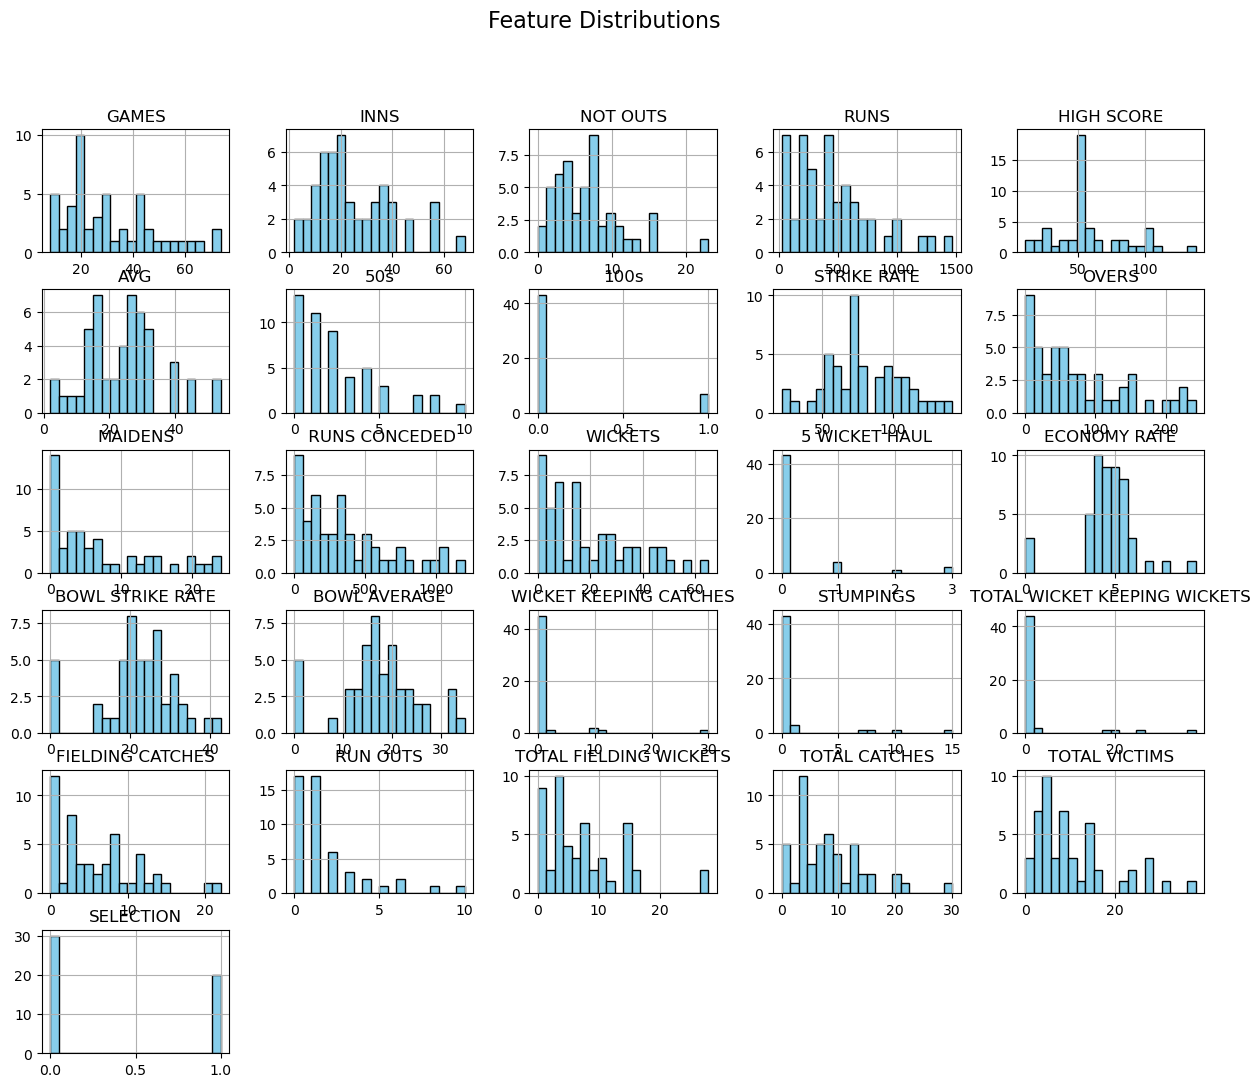

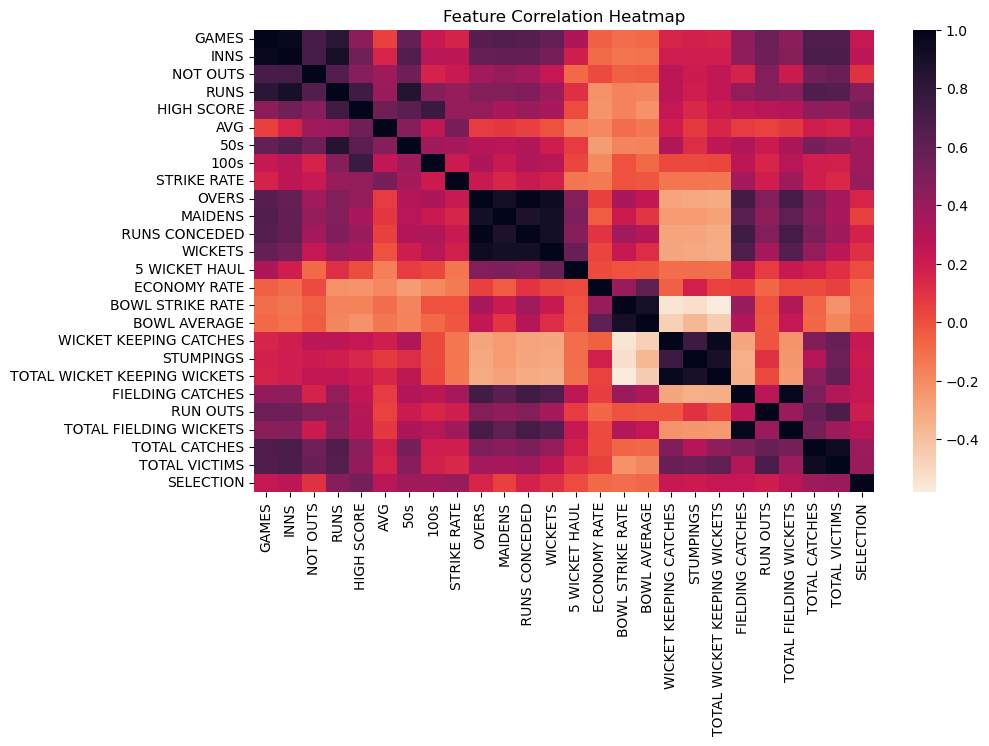

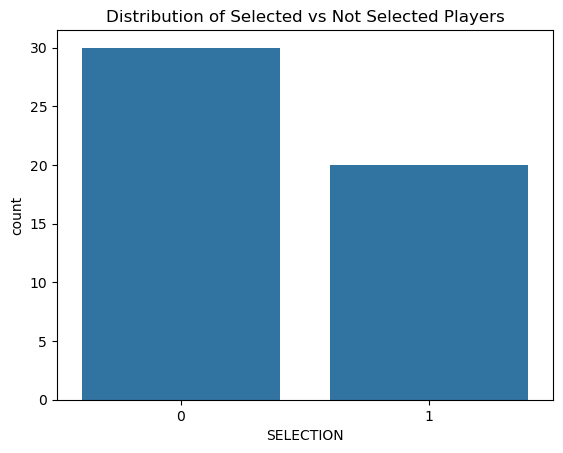

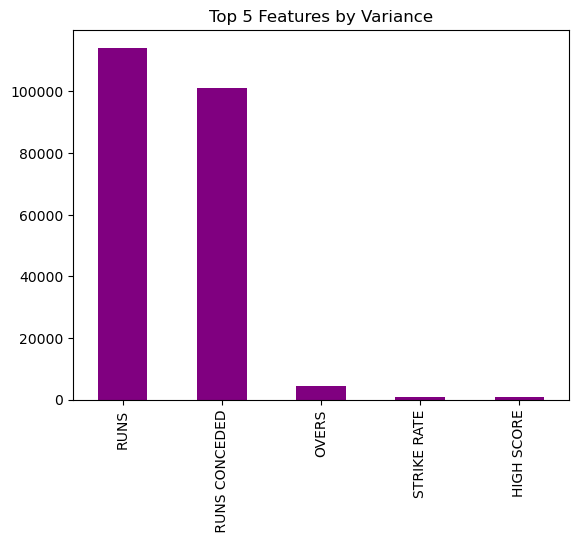

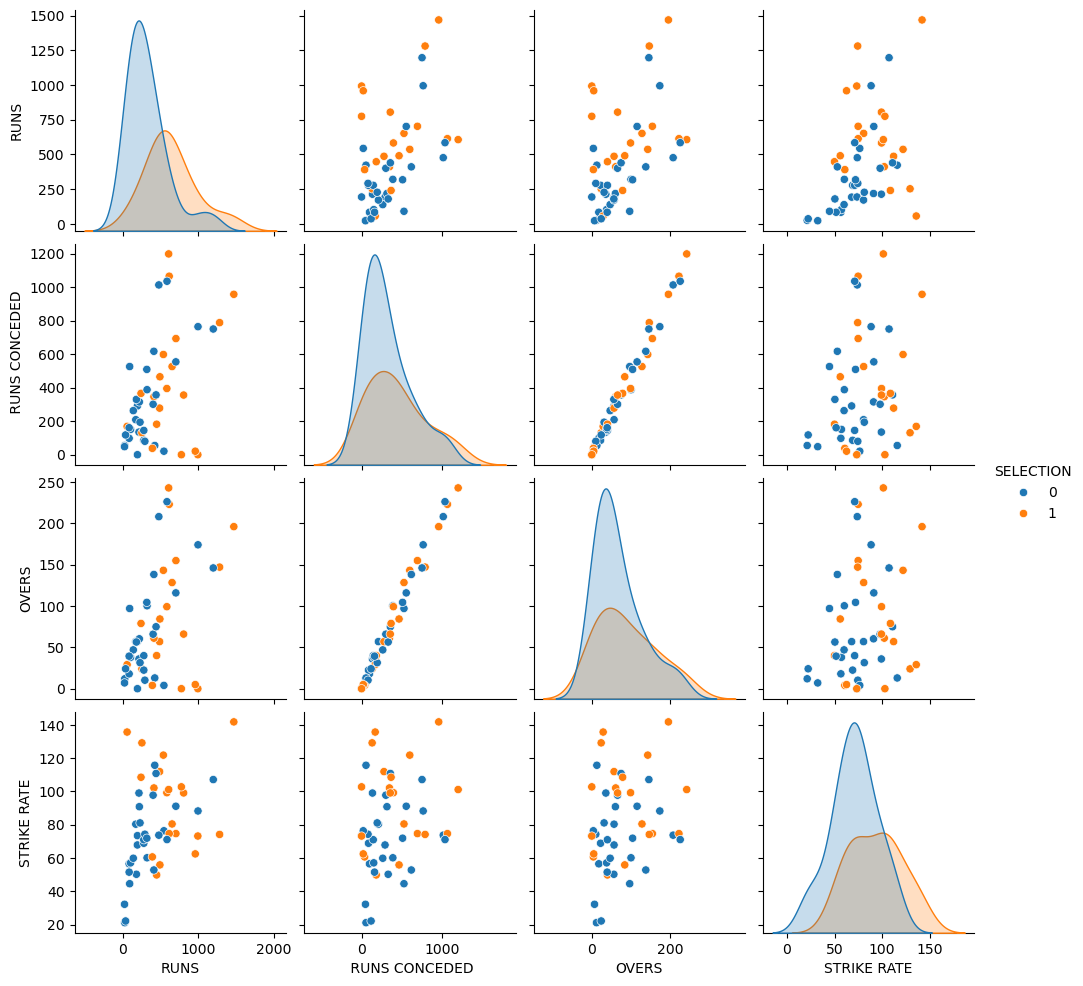

In [136]:
#Feature Distribution Matrix:

numcols = cdata.select_dtypes(include=['float64', 'int64']).columns
cdata[numcols].hist(figsize=(15, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

#Correlation Heatmap:

plt.figure(figsize=(10, 6))
sns.heatmap(cdata[numcols].corr(), annot=False, cmap="rocket_r")
plt.title("Feature Correlation Heatmap")
plt.show()

#Distribution of Seelected Players (selected vs non-selected):

sns.countplot(x="SELECTION", data=cdata[numcols])
plt.title("Distribution of Selected vs Not Selected Players")
plt.show()

#Top 5 Most Imp. Features (by Variance):

cdata[numcols].var().sort_values(ascending=False).head(5).plot(kind="bar", color="purple")
plt.title("Top 5 Features by Variance")
plt.show()

#Top 4 Most Imp. Features, as Pairplots (wrt Selection):

top_features = cdata[numcols].var().sort_values(ascending=False).head(4).index
sns.pairplot(cdata[top_features.tolist() + ['SELECTION']], hue="SELECTION")
plt.show()



## _Train-Test Split and XGBoost Model_

Ensemble Test Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



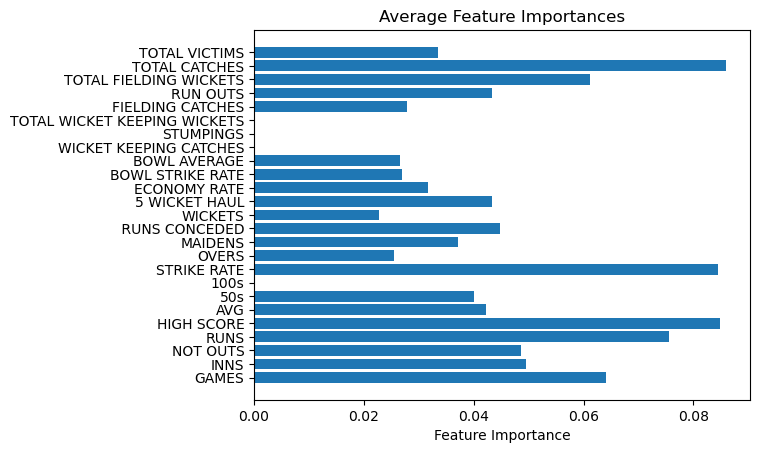

Top 20 Players:
                  Player  GAMES  INNS  NOT OUTS    RUNS  HIGH SCORE    AVG  \
17          Riley Sayer   20.0  19.0       4.0   487.0        56.0  32.47   
24         Harry Walker   25.0  22.0       3.0   537.0       138.0  28.26   
31        Harry Simpson   34.0  26.0       6.0   607.0        97.0  30.35   
33         Joel Soppitt   37.0  33.0       4.0   652.0       101.0  22.48   
3           Joey Hayman   11.0  11.0       3.0   253.0        61.0  38.33   
28            Jack Hood   30.0  25.0      12.0   583.0       105.0  44.85   
18          Henry Wilds   20.0  18.0       2.0   412.0        52.0  25.75   
15       Luke Frankland   20.0  19.0       4.0   448.0        75.0  28.00   
36             Sam Hood   44.0  38.0      16.0   703.0        87.0  31.95   
39        Bertie Morris   44.0  35.0       5.0   775.0        55.0  25.83   
37            Josh Lane   44.0  40.0       8.0   993.0       107.0  31.03   
41         Matthew King   45.0  38.0       3.0   491.0     

In [137]:
#Preparing the Data:
X = cdata[numcols].drop(columns=["SELECTION"])
y = cdata["SELECTION"]

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Ensemble Models Setup (Average of Models)
n = 5   #Number of models 
ptrain = np.zeros(X_train.shape[0])
ptest = np.zeros(X_test.shape[0])
pfull = np.zeros(X.shape[0])  #Storing top-20 prediction

models = []

#Loop to run 5 models until convergeance
for s in range(n):
    model = xgb.XGBClassifier(eval_metric="logloss", max_depth=4, learning_rate=0.05, n_estimators=150, subsample=0.8, colsample_bytree=0.8, random_state=s)
    model.fit(X_train, y_train)
    models.append(model)
    
    #Accumulating predictions
    ptrain = ptrain + model.predict_proba(X_train)[:, 1]
    ptest = ptest + model.predict_proba(X_test)[:, 1]
    pfull = pfull + model.predict_proba(X)[:, 1]

#Average Predictions
ptrain = (ptrain)/n
ptest = (ptest)/n
pfull = (pfull)/n

#Evaluating it on the Test Set
y_pred = (ptest >= 0.5).astype(int)
print("Ensemble Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Feature Importance
importances = np.zeros(X.shape[1])
for model in models:
    importances += model.feature_importances_
importances /= n

plt.barh(X.columns, importances)
plt.xlabel("Feature Importance")
plt.title("Average Feature Importances")
plt.show()

#Getting the List of Top 20 Players
cdata["Prediction_Prob"] = pfull
top20 = cdata.sort_values(by="Prediction_Prob", ascending=False).head(20)
print("Top 20 Players:\n", top20)
top20.to_csv("top20_players.csv", index=False)

## SHAP (SHapley Additive exPlanations)

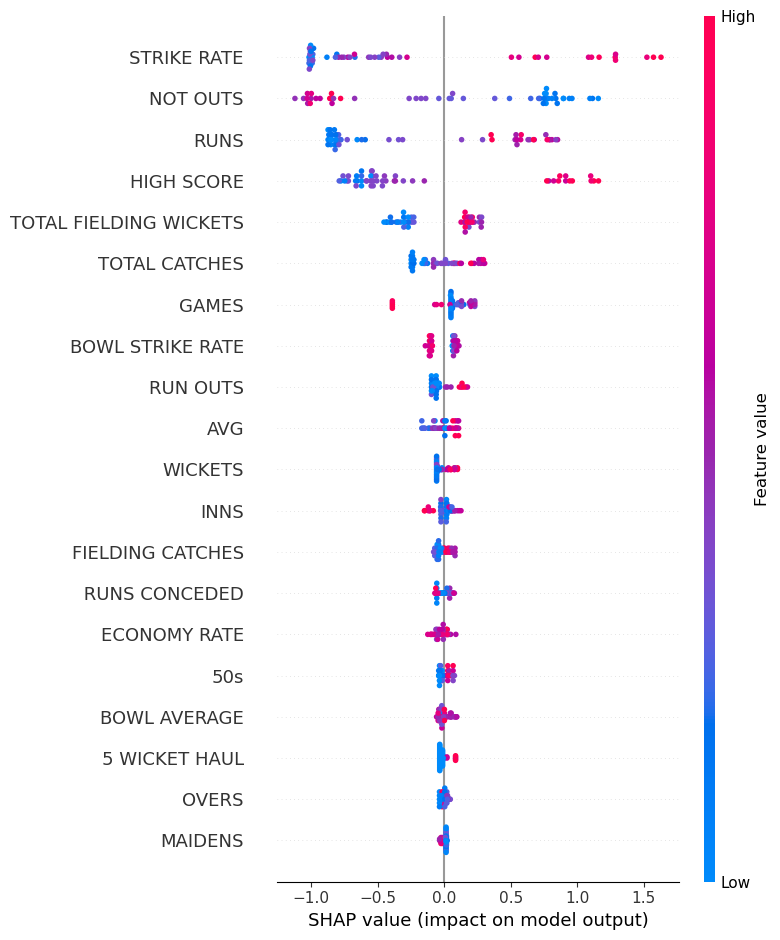

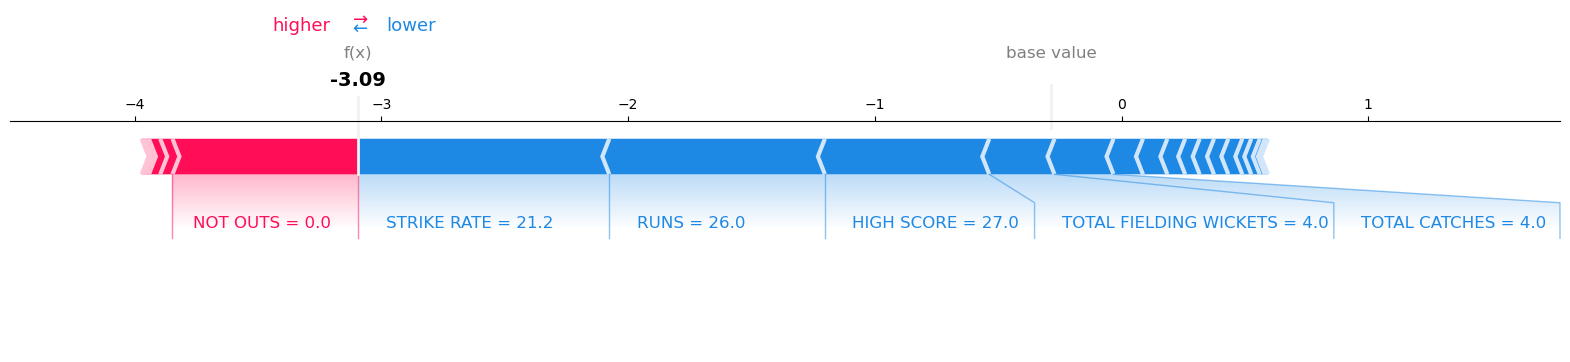

<Figure size 640x480 with 0 Axes>

In [139]:
#Initialising SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

#Building a SHAP Summary Plot
shap.summary_plot(shap_values, X)

#Building a force plot to explain a single player 
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)
plt.tight_layout()
plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()